In [2]:
import numpy as np
import pandas as pd
from stable_baselines3 import PPO
from stable_baselines3.common.vec_env import DummyVecEnv, VecNormalize
from stable_baselines3.common.monitor import Monitor
import gymnasium as gym
import matplotlib.pyplot as plt
from collections import deque

In [3]:
# @misc{towers_gymnasium_2023, 

#         title = {Gymnasium}, 

#         url = {https://zenodo.org/record/8127025}, 

#         abstract = {An API standard for single-agent reinforcement learning environments, with popular reference environments and related utilities (formerly Gym)}, 

#         urldate = {2023-07-08}, 

#         publisher = {Zenodo}, 

#         author = {Towers, Mark and Terry, Jordan K. and Kwiatkowski, Ariel and Balis, John U. and Cola, Gianluca de and Deleu, Tristan and Goulão, Manuel and Kallinteris, Andreas and KG, Arjun and Krimmel, Markus and Perez-Vicente, Rodrigo and Pierré, Andrea and Schulhoff, Sander and Tai, Jun Jet and Shen, Andrew Tan Jin and Younis, Omar G.}, 

#         month = mar, 

#         year = {2023}, 

#         doi = {10.5281/zenodo.8127026}, 

# } 

class Environnment2(gym.Env):
    def __init__(self, render_mode=None, price_change_up=0.01, price_change_down=-0.01, initial_wealth=1, kelly_bet_size=0.1, max_steps = 100, mult = False, bankrupt = False, print_kelly = False, log_diff_reward = False):
        super(Environnment2, self).__init__()
        self.render_mode = render_mode
        self.price_change_up = price_change_up  # Price change if it goes up
        self.price_change_down = price_change_down  # Price change if it goes down
        self.initial_wealth = initial_wealth
        self.current_wealth = self.initial_wealth
        self.kelly_bet_size = kelly_bet_size

        self.log_diff_reward = log_diff_reward

        self.mult = mult
        self.bankrupt = bankrupt
        
        self.current_step = 1
        self.max_steps = max_steps
        self.state = [self.initial_wealth]

        self.print_kelly = print_kelly
        
        self.old_cagr = 0
        self.reward = 0
        self.pnl = 0
        self.min_bet_size = 0.05
        
        self.episode_bet_size_list = []
        self.episode_wealth_list = [self.initial_wealth]

        self.all_bet_size_list = []
        self.all_wealth_list = [self.initial_wealth]

        # Define action and observation space
        self.action_space = gym.spaces.Box(low=0, high=1, shape=(1,), dtype=np.float32)  # Bet size only
        self.observation_space = gym.spaces.Box(low=0, high=np.inf, shape=(1,), dtype=np.float32)  # Current wealth

    def update_state(self):
        if self.current_wealth > self.initial_wealth:
            self.state = [1]
        else:
            ratio = (self.initial_wealth - self.min_bet_size) / self.initial_wealth
            self.state = [ratio]
        return self.state

    def step(self, action):
        bet_size = action[0]
        if self.mult:
            bet_amount = self.current_wealth * bet_size
        else:
            bet_amount = self.initial_wealth * bet_size
        if bet_amount < self.min_bet_size:
            bet_amount = 0

        # Simulate price change
        price_change = np.random.choice([self.price_change_up, self.price_change_down])
        self.pnl = bet_amount * price_change
        new_wealth = self.current_wealth
        new_wealth += self.pnl
        if self.log_diff_reward:
            new_wealth = max(new_wealth,0.0001) # prevent log 0
            log_diff = np.log(new_wealth) - np.log(self.current_wealth)
            self.reward = log_diff

        else:
            self.reward = self.pnl

        self.current_wealth = new_wealth

        # Update state and lists
        self.episode_bet_size_list.append(bet_size)
        self.episode_wealth_list.append(self.current_wealth)
        self.current_step += 1

        if self.bankrupt:
            done = self.current_step >= self.max_steps  or self.current_wealth < self.min_bet_size
        else:
            done = self.current_step >= self.max_steps
            
        info = {'curr_reward': self.reward}

        if done:
            self.all_bet_size_list.extend(self.episode_bet_size_list)
            self.all_wealth_list.extend(self.episode_wealth_list[1:])

        self.state = self.update_state()
        return np.array(self.state), self.reward, done, False, info

    def reset(self, **kwargs):
        self.current_step = 1
        self.current_wealth = self.initial_wealth
        self.old_cagr = 0
        self.reward = 0
        self.pnl = 0
        self.state = [self.initial_wealth]
        self.episode_bet_size_list = []
        self.episode_wealth_list = [self.initial_wealth]
        return np.array(self.state), {}

    def render(self, mode='human'):
        if mode == 'human':
            plt.figure(figsize=(12, 8))

            plt.subplot(2, 1, 1)
            plt.plot(self.all_wealth_list, label='Wealth')
            plt.xlabel('Step')
            plt.ylabel('Wealth')
            plt.title('Wealth Over Time')
            plt.legend()

            # Plot histogram of bet sizes with the Kelly bet size
            plt.subplot(2, 1, 2)
            plt.hist(self.all_bet_size_list, bins=10, range=(0,1), alpha=0.7, label='Bet Sizes')
            avg_bet_size = np.mean(self.all_bet_size_list) if self.all_bet_size_list else 0
            if self.print_kelly:
                plt.axvline(self.kelly_bet_size, color='r', linestyle='dashed', linewidth=1, label=f'Kelly: {self.kelly_bet_size}')
            plt.axvline(avg_bet_size, color='g', linestyle='dashed', linewidth=1, label=f'Avg: {avg_bet_size:.2f}')
            if self.print_kelly:
                plt.title(f'Bet Sizes - Avg: {avg_bet_size:.2f}, Kelly Betsize {self.kelly_bet_size}')
            else:
                plt.title(f'Bet Sizes - Avg: {avg_bet_size:.2f}')
            plt.xlabel('Bet Size')
            plt.ylabel('Frequency')
            plt.legend()
            
            plt.tight_layout()
        plt.show()


In [4]:
# Create environments for different scenarios
# env1 = Environnment2(price_change_up=0.9, price_change_down=-0.1, kelly_bet_size=1, render_mode="human", mult = False, bankrupt = False)
env2 = Environnment2(price_change_up=0.5, price_change_down=-0.5, kelly_bet_size=0.5, render_mode="human")
# env3 = Environnment2(price_change_up=0.1, price_change_down=-0.9, kelly_bet_size=0, render_mode="human", mult = False, bankrupt = False)

# Wrap the environments with DummyVecEnv
# env1 = DummyVecEnv([lambda: env1])
env2 = DummyVecEnv([lambda: env2])
# env3 = DummyVecEnv([lambda: env3])

# Train the agent on each environment
# agent1 = PPO("MlpPolicy", env1, verbose=0)
# agent1.learn(total_timesteps=100_000, progress_bar=True)

agent2 = PPO("MlpPolicy", env2, verbose=0)
agent2.learn(total_timesteps=100_000, progress_bar=True)

# agent3 = PPO("MlpPolicy", env3, verbose=0)
# agent3.learn(total_timesteps=100_000, progress_bar=True)


Output()

In [12]:
# Create environments for different scenarios
# test_env1 = Environnment2(price_change_up=0.9, price_change_down=-0.1, kelly_bet_size=1, render_mode="human", max_steps=100)
test_env2 = Environnment2(price_change_up=0.5, price_change_down=-0.5, kelly_bet_size=0, render_mode="human", max_steps=100)
# test_env3 = Environnment2(price_change_up=0.1, price_change_down=-0.9, kelly_bet_size=0, render_mode="human", max_steps=100)

# Wrap the environments with DummyVecEnv
# test_env1 = DummyVecEnv([lambda: test_env1])
test_env2 = DummyVecEnv([lambda: test_env2])
# test_env3 = DummyVecEnv([lambda: test_env3])

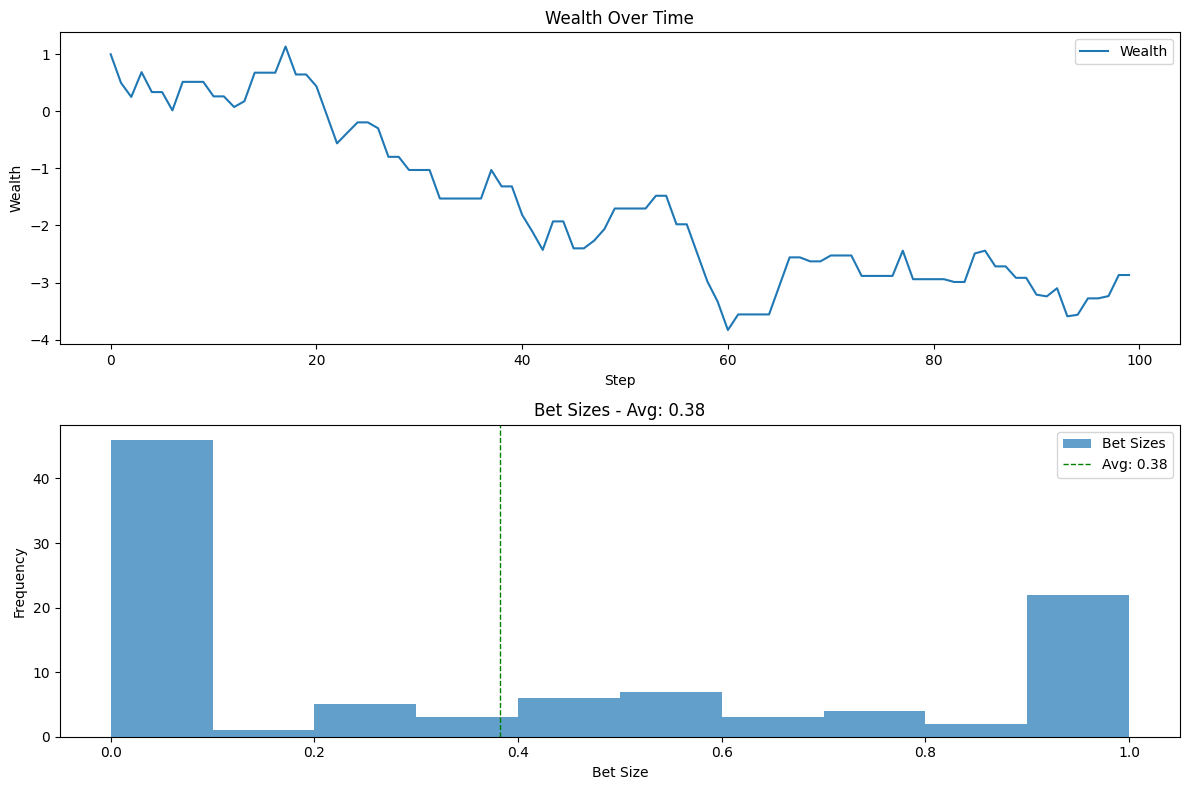

In [13]:
def render_and_plot(env, agent, num_steps=100):
    agent = agent2
    obs, _ = env.reset()
    done = False
    for i in range(num_steps):
        action, _ = agent.predict(obs)
        obs, _, done, _, _ = env.step(action)
        if done:
            break

    # Render the final result
    env.render()

# Render and plot results for each environment
# render_and_plot(test_env1.envs[0], agent1)
render_and_plot(test_env2.envs[0], agent2)
# render_and_plot(test_env3.envs[0], agent3)


In [7]:
# Create environments for different scenarios
slight_edge_env = Environnment2(price_change_up=1.1, price_change_down=-1, kelly_bet_size=1, render_mode="human", mult = False, bankrupt = False)

# Wrap the environments with DummyVecEnv
slight_edge_env = DummyVecEnv([lambda: slight_edge_env])

# Train the agent on each environment
slight_edge_agent = PPO("MlpPolicy", slight_edge_env, verbose=0)
slight_edge_agent.learn(total_timesteps=100_000, progress_bar=True)


Output()

In [8]:
# Create environments for different scenarios
slight_edge_test_env = Environnment2(price_change_up=1.1, price_change_down=-1, kelly_bet_size=1, render_mode="human", max_steps=100, bankrupt = False)

# Wrap the environments with DummyVecEnv
slight_edge_test_env = DummyVecEnv([lambda: slight_edge_test_env])

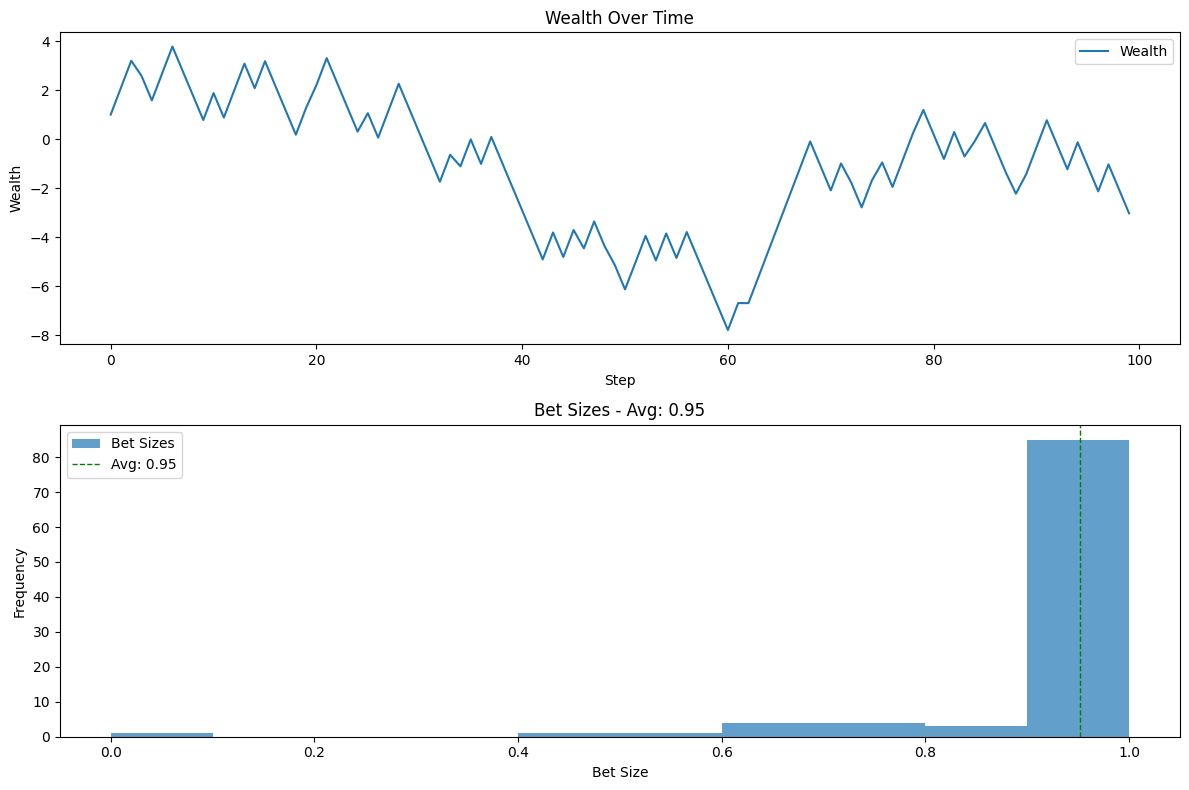

In [9]:
def render_and_plot(env, agent, num_steps=100):
    obs, _ = env.reset()
    done = False
    for i in range(num_steps):
        action, _ = agent.predict(obs)
        obs, _, done, _, _ = env.step(action)
        if done:
            break

    # Render the final result
    env.render()

# Render and plot results for each environment
render_and_plot(slight_edge_test_env.envs[0], slight_edge_agent)



In [ ]:
# Create environments for different scenarios
# env4 = Environnment2(price_change_up=2, price_change_down=-0.4, kelly_bet_size=1, render_mode="human", max_steps=100, mult = True, bankrupt = True, print_kelly=True, log_diff_reward=True)
env5 = Environnment2(price_change_up=1, price_change_down=-0.5, kelly_bet_size=0.5, render_mode="human", max_steps=100, mult = True, bankrupt = True, log_diff_reward=True)
# env6 = Environnment2(price_change_up=0.5, price_change_down=-0.5, kelly_bet_size=0, render_mode="human", max_steps=100, mult = True, bankrupt = True, log_diff_reward=True)

# Wrap the environments with DummyVecEnv
# env4 = DummyVecEnv([lambda: env4])
env5 = DummyVecEnv([lambda: env5])
# env6 = DummyVecEnv([lambda: env6])

# Train the agent on each environment
# agent4 = PPO("MlpPolicy", env4, verbose=0)
# agent4.learn(total_timesteps=100_000, progress_bar=True)

agent5 = PPO("MlpPolicy", env5, verbose=0)
agent5.learn(total_timesteps=1_000_000, progress_bar=True)

# agent6 = PPO("MlpPolicy", env6, verbose=0)
# agent6.learn(total_timesteps=100_000, progress_bar=True)


In [ ]:
# Create environments for different scenarios
# test_env4 = Environnment2(price_change_up=2, price_change_down=-0.4, kelly_bet_size=1, render_mode="human", max_steps=100, mult = True, bankrupt = True, print_kelly=True, log_diff_reward=True)
test_env5 = Environnment2(price_change_up=1, price_change_down=-0.5, kelly_bet_size=0.5, render_mode="human", max_steps=100, mult = True, bankrupt = True, print_kelly=True, log_diff_reward=True)
# test_env6 = Environnment2(price_change_up=0.5, price_change_down=-0.5, kelly_bet_size=0, render_mode="human", max_steps=100, mult = True, bankrupt = True, print_kelly=True, log_diff_reward=True)

# Wrap the environments with DummyVecEnv
# test_env4 = DummyVecEnv([lambda: test_env4])
test_env5 = DummyVecEnv([lambda: test_env5])
# test_env6 = DummyVecEnv([lambda: test_env6])

In [ ]:
def render_and_plot(env, agent, num_steps=100):
    obs, _ = env.reset()
    done = False
    for i in range(num_steps):
        action, _ = agent.predict(obs)
        obs, _, done, _, _ = env.step(action)
        if done:
            break

    # Render the final result
    env.render()

# Render and plot results for each environment
# render_and_plot(test_env4.envs[0], agent4)
render_and_plot(test_env5.envs[0], agent5)
# render_and_plot(test_env6.envs[0], agent6)


In [ ]:
# Create environments for different scenarios
env7 = Environnment2(price_change_up=2, price_change_down=-0.4, kelly_bet_size=1, render_mode="human", max_steps=100, mult = True, bankrupt = True, print_kelly=True, cagr_diff_reward=True)
env8 = Environnment2(price_change_up=1, price_change_down=-0.5, kelly_bet_size=0.5, render_mode="human", max_steps=100, mult = True, bankrupt = True, cagr_diff_reward=True)
env9 = Environnment2(price_change_up=0.5, price_change_down=-0.5, kelly_bet_size=0, render_mode="human", max_steps=100, mult = True, bankrupt = True, cagr_diff_reward=True)

# Wrap the environments with DummyVecEnv
env7 = DummyVecEnv([lambda: env7])
env8 = DummyVecEnv([lambda: env8])
env9 = DummyVecEnv([lambda: env9])

# Train the agent on each environment
# agent7 = PPO("MlpPolicy", env7, verbose=0)
# agent7.learn(total_timesteps=10_00_000, progress_bar=True)

agent8 = PPO("MlpPolicy", env8, verbose=0)
agent8.learn(total_timesteps=1_000_000, progress_bar=True)

# agent9 = PPO("MlpPolicy", env9, verbose=0)
# agent9.learn(total_timesteps=1_000_000, progress_bar=True)


In [ ]:
# Create environments for different scenarios
# test_env7 = Environnment2(price_change_up=2, price_change_down=-0.4, kelly_bet_size=1, render_mode="human", max_steps=100, mult = True, bankrupt = True, print_kelly=True, cagr_diff_reward=True)
test_env8 = Environnment2(price_change_up=1, price_change_down=-0.5, kelly_bet_size=0.5, render_mode="human", max_steps=100, mult = True, bankrupt = True, print_kelly=True, cagr_diff_reward=True)
# test_env9 = Environnment2(price_change_up=0.5, price_change_down=-0.5, kelly_bet_size=0, render_mode="human", max_steps=100, mult = True, bankrupt = True, print_kelly=True, cagr_diff_reward=True)

# Wrap the environments with DummyVecEnv
# test_env7 = DummyVecEnv([lambda: test_env7])
test_env8 = DummyVecEnv([lambda: test_env8])
# test_env9 = DummyVecEnv([lambda: test_env9])

In [ ]:
def render_and_plot(env, agent, num_steps=100):
    obs, _ = env.reset()
    done = False
    for i in range(num_steps):
        action, _ = agent.predict(obs)
        obs, _, done, _, _ = env.step(action)
        if done:
            break

    # Render the final result
    env.render()

# Render and plot results for each environment
render_and_plot(test_env8.envs[0], agent8)
